In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/My Drive/PA ORBIT/archive_2.zip'

Archive:  /content/drive/My Drive/PA ORBIT/archive_2.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fake_face/training_fake/easy_112_1001.jpg  
  inflating: real_an

In [ ]:
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=50

In [ ]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "real_and_fake_face_detection/real_and_fake_face/",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 2041 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['training_fake', 'training_real']

training real : 1081
training fake : 960


<BarContainer object of 2 artists>

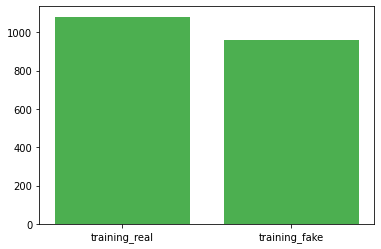

In [ ]:
import matplotlib.pyplot as plt

r=0
f=0
for image,label in dataset:
    for cek in label:
        if cek==int(1):
            r+=1
        elif cek==int(0):
            f+=1
training = {'training_real':r,'training_fake':f}
print(f'training real : {r}\ntraining fake : {f}')
plt.bar(training.keys(),training.values(),color = '#4CAF50')

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1]


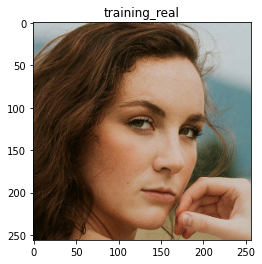

In [ ]:
import matplotlib.pyplot as plt

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [ ]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

51 6 7


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),  
])

In [ ]:
from tensorflow.keras import models

input_shape = (32,256, 256,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'sigmoid'),
])

model.build(input_shape=input_shape)
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
history = model.fit(
    train_ds,
    epochs=200,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/200
51/51 [==============================] - 30s 95ms/step - loss: 0.7501 - accuracy: 0.4663 - val_loss: 0.6977 - val_accuracy: 0.5135
Epoch 2/200
51/51 [==============================] - 5s 92ms/step - loss: 0.7024 - accuracy: 0.5129 - val_loss: 0.6966 - val_accuracy: 0.5202
Epoch 3/200
51/51 [==============================] - 5s 95ms/step - loss: 0.7004 - accuracy: 0.5172 - val_loss: 0.7197 - val_accuracy: 0.4798
Epoch 4/200
51/51 [==============================] - 5s 93ms/step - loss: 0.7060 - accuracy: 0.5086 - val_loss: 0.7033 - val_accuracy: 0.4804
Epoch 5/200
51/51 [==============================] - 5s 93ms/step - loss: 0.6984 - accuracy: 0.5086 - val_loss: 0.6993 - val_accuracy: 0.4804
Epoch 6/200
51/51 [==============================] - 5s 93ms/step - loss: 0.6980 - accuracy: 0.4994 - val_loss: 0.7014 - val_accuracy: 0.5202
Epoch 7/200
51/51 [==============================] - 5s 93ms/step - loss: 0.7003 - accuracy: 0.5031 - val_loss: 0.6966 - val_accuracy: 0.5202
Epoch

In [ ]:
model.evaluate(test_ds)

51/51 [==============================] - 1s 28ms/step - loss: 0.3034 - accuracy: 0.8603


[0.3033977448940277, 0.8602941036224365]

In [ ]:
!mkdir '/content/img_tes/'

In [ ]:
from PIL import Image
import numpy as np
from tensorflow.python.keras import backend

pred = []
lbl = []
for j in range(7):
  for image_batch,label_batch in test_ds.take(j):
    it = image_batch.get_shape().as_list()
    for i in range(int(it[0])): 
      img = Image.fromarray(image_batch[i].numpy().astype("uint8"))
      img = img.resize((256,256))
      img.save('/content/img_tes/gbr_'+str(i)+'.png')
      data_contoh = tf.keras.preprocessing.image.load_img('/content/img_tes/gbr_'+str(i)+'.png')
      data_contoh = tf.keras.preprocessing.image.img_to_array(data_contoh)
      data_contoh = np.stack([data_contoh])
      prediksi = model.predict(data_contoh)
      pred.append(np.argmax(prediksi))
    for label in label_batch:
      lbl.append(int(label))
    

Confusion matrix : 
 [[258  58]
 [ 29 327]]
Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       316
           1       0.85      0.92      0.88       356

    accuracy                           0.87       672
   macro avg       0.87      0.87      0.87       672
weighted avg       0.87      0.87      0.87       672



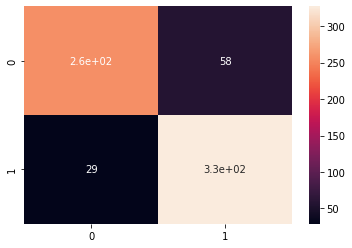

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

cm = confusion_matrix(lbl,pred)
print('Confusion matrix : \n',cm)
sns.heatmap(cm,annot = True)
matrix = classification_report(lbl,pred)
print('Classification report : \n',matrix)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


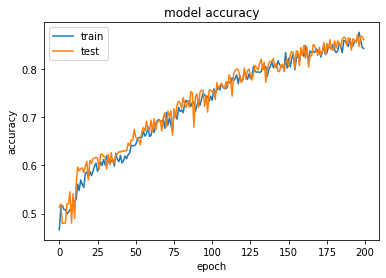

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

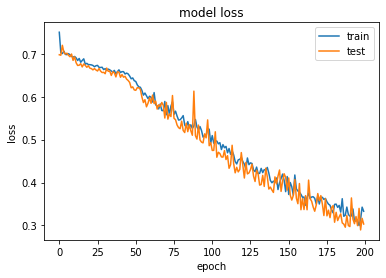

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

aktual : training_real
prediksi : training_real


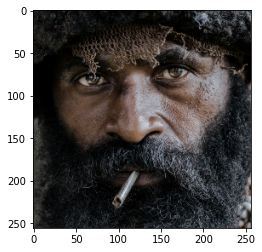

In [ ]:
import numpy as np

for image,label in test_ds.take(1):
  img = image[0].numpy().astype('uint8')
  lbl = label[0].numpy()
  pred = model.predict(image)
  plt.imshow(img)
  print(f'aktual : {class_names[lbl]}\nprediksi : {class_names[np.argmax(pred[0])]}')

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tfmodel = converter.convert() 
open ('model_tes.tflite' , "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpuwrhx20f/assets


741000

In [ ]:
my_model = tf.lite.Interpreter('/content/model_tes.tflite')

In [ ]:
my_model.allocate_tensors()

In [ ]:
input = my_model.get_input_details()
output = my_model.get_output_details()

In [ ]:
data_contoh = tf.keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/foto_lucu.png'
)
input_arr = tf.keras.preprocessing.image.img_to_array(data_contoh)

In [ ]:
from PIL import  Image

img = Image.fromarray(input_arr.astype(np.uint8))
img = img.resize((256,256))
img = np.array(img,dtype=np.float32)
img = img / 255
imag = np.expand_dims(img,axis=0)
my_model.set_tensor(input[0]['index'],imag)
my_model.invoke()
hasil = my_model.get_tensor(output[0]['index'])
hasil